# SECOND CHALLENGE 

# Time Series Forecasting 

In [1]:
# Import all the libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Fix the seed of the random generators
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Dataset Analysis

In [3]:
dataset = pd.read_csv('../input/training/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


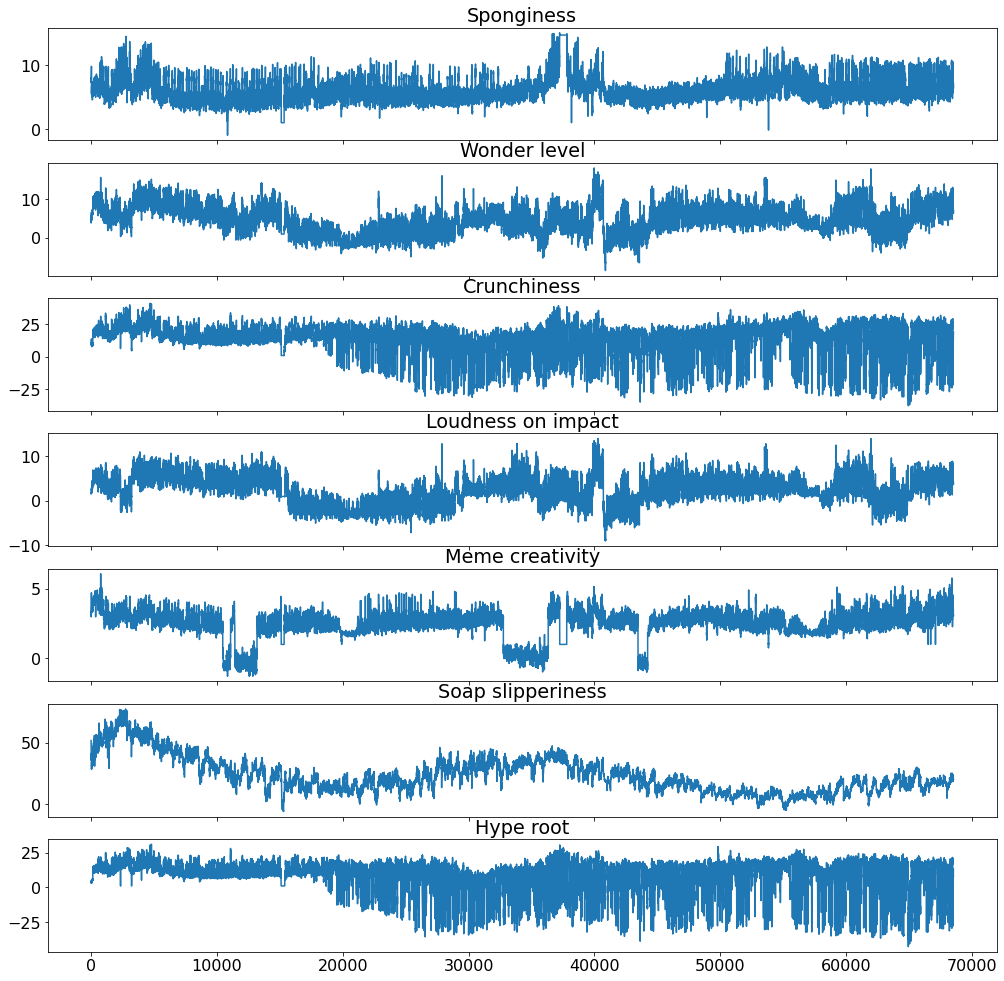

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Call the fuction and inspect the DataSet 
inspect_dataframe(dataset, dataset.columns)

(64528, 7) (4000, 7)


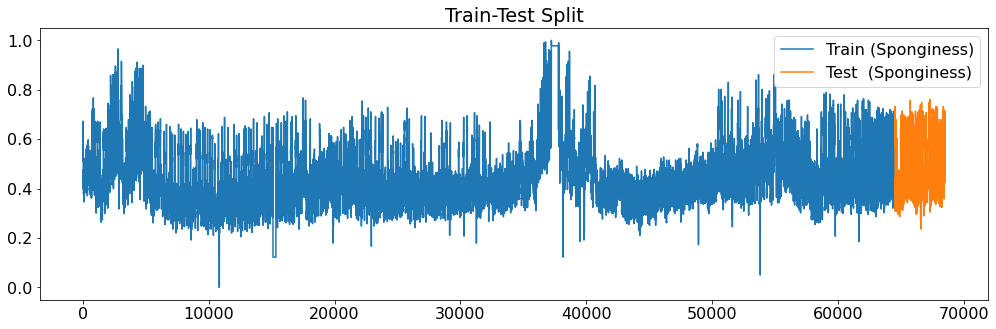

In [6]:
# Train-Test split of the dataset 
test_size = 4000

# TRAINING SET 
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
# TEST SET 
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]

print(X_train_raw.shape, X_test_raw.shape)

# NORMALIZATION both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw  = (X_test_raw-X_min) /(X_max-X_min)

# Plot 
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess,  label='Test  (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
# Function that builds the sequences that are used for training the network 
# NB this version works with only one input 'Sponginess'
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels  = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
# Plots the samples of training and testing 
# The first blu part is used to predict and the second orange part is the one
# that we wish to predict correctly 
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [15]:
# MODEL
# Bidirectional LSTM model 

def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope * num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [21]:
# Function that plots each sample with the prediction period and the true prediction given by the model 
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

# Auto Regressive Model 

### It predicts day (/telescope) by day (/telescope) and adjust the time window at every step to include its last prediction 

In [26]:
# Labels that we want to predict 
target_labels = dataset.columns
# Model parameters 
telescope = 16
window    = 200
stride    = 10

In [27]:
# Train Test division in sequeces 
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test   = build_sequences(X_test_raw,  target_labels, window, stride, telescope)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6439, 200, 7), (6439, 16, 7), (379, 200, 7), (379, 16, 7))

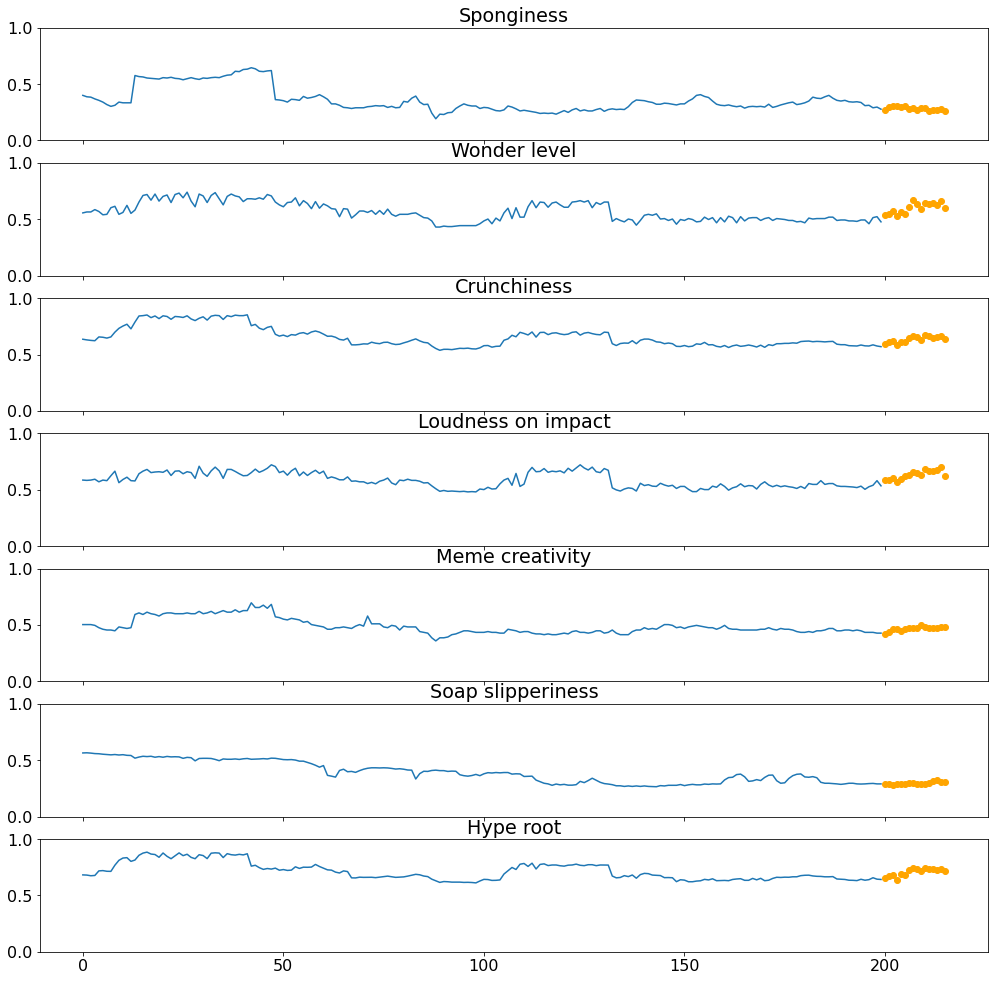

In [28]:
# See the samples
inspect_multivariate(X_train, y_train, target_labels, telescope)

## AR model training 

In [29]:
input_shape  = X_train.shape[1:]
output_shape = y_train.shape[1:]
# Trining phase parameters 
batch_size = 64
epochs     = 200

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          36864     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0     

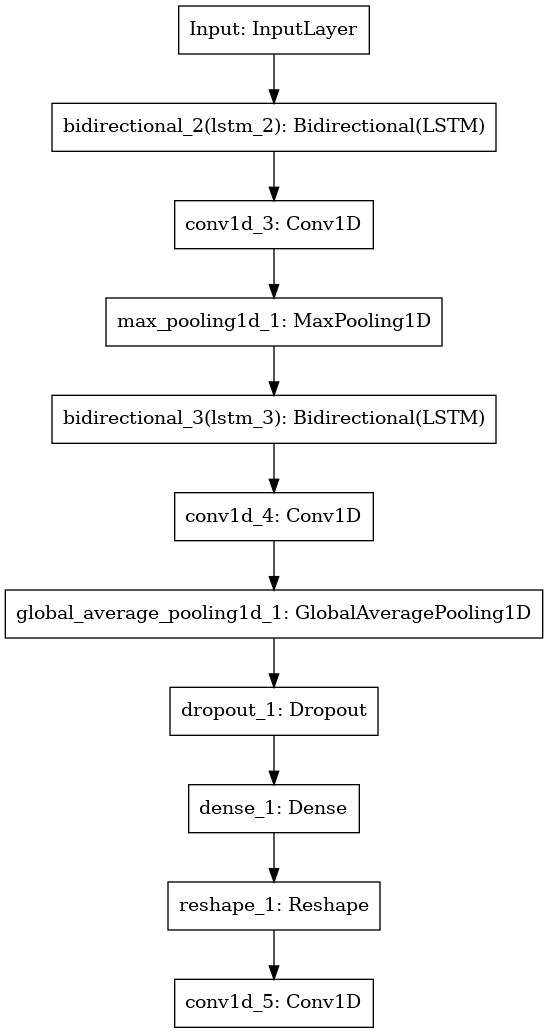

In [30]:
# Construct the model 
model = build_CONV_LSTM_model(input_shape, output_shape)
# Model Summary 
model.summary()
# Plot model scheme
tfk.utils.plot_model(model, expand_nested=True)

In [31]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
91/91 [==============================] - 10s 48ms/step - loss: 0.1934 - mae: 0.3886 - val_loss: 0.0725 - val_mae: 0.2184
Epoch 2/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0409 - mae: 0.1553 - val_loss: 0.0232 - val_mae: 0.1073
Epoch 3/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0188 - mae: 0.1052 - val_loss: 0.0216 - val_mae: 0.1034
Epoch 4/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0169 - mae: 0.0993 - val_loss: 0.0202 - val_mae: 0.1044
Epoch 5/200
91/91 [==============================] - 3s 36ms/step - loss: 0.0155 - mae: 0.0953 - val_loss: 0.0190 - val_mae: 0.1093
Epoch 6/200
91/91 [==============================] - 3s 35ms/step - loss: 0.0145 - mae: 0.0926 - val_loss: 0.0173 - val_mae: 0.0968
Epoch 7/200
91/91 [==============================] - 3s 37ms/step - loss: 0.0138 - mae: 0.0901 - val_loss: 0.0154 - val_mae: 0.0903
Epoch 8/200
91/91 [==============================] - 3s 37ms/step - loss: 0

In [32]:
# Save the model 
model.save("Delvi_AR_mod_01")

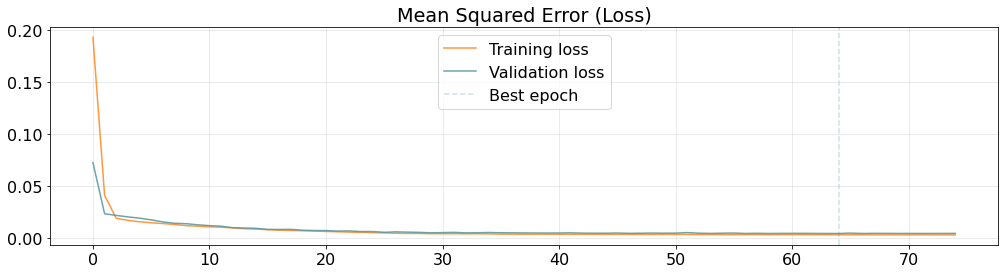

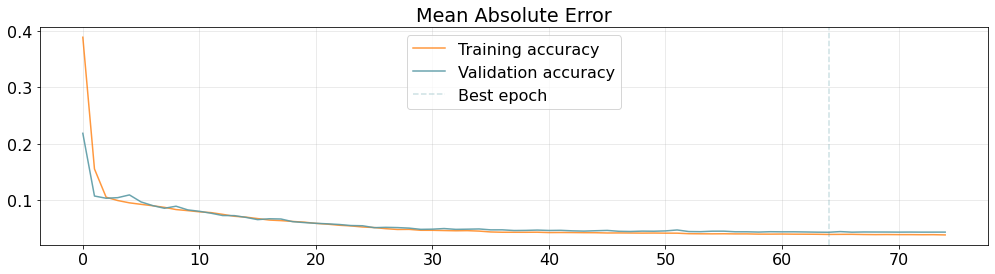

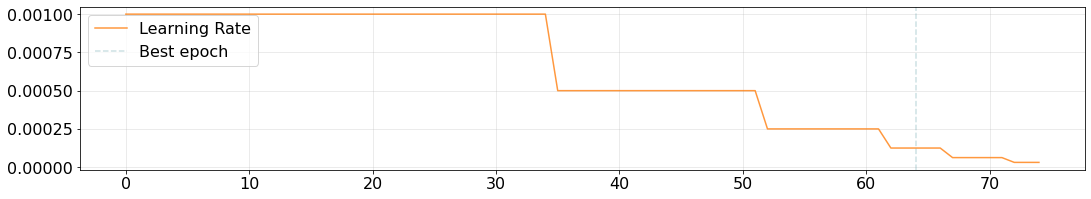

In [33]:
# Visualize model performance in training phase 
best_epoch = np.argmin(history['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Learning Rate')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Predict the TEST SET with the AR model 

In [34]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(379, 16, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0038749638>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.042381085>)

In [35]:
predictions.shape

(379, 16, 7)

In [36]:
y_test.shape
X_test.shape

(379, 200, 7)

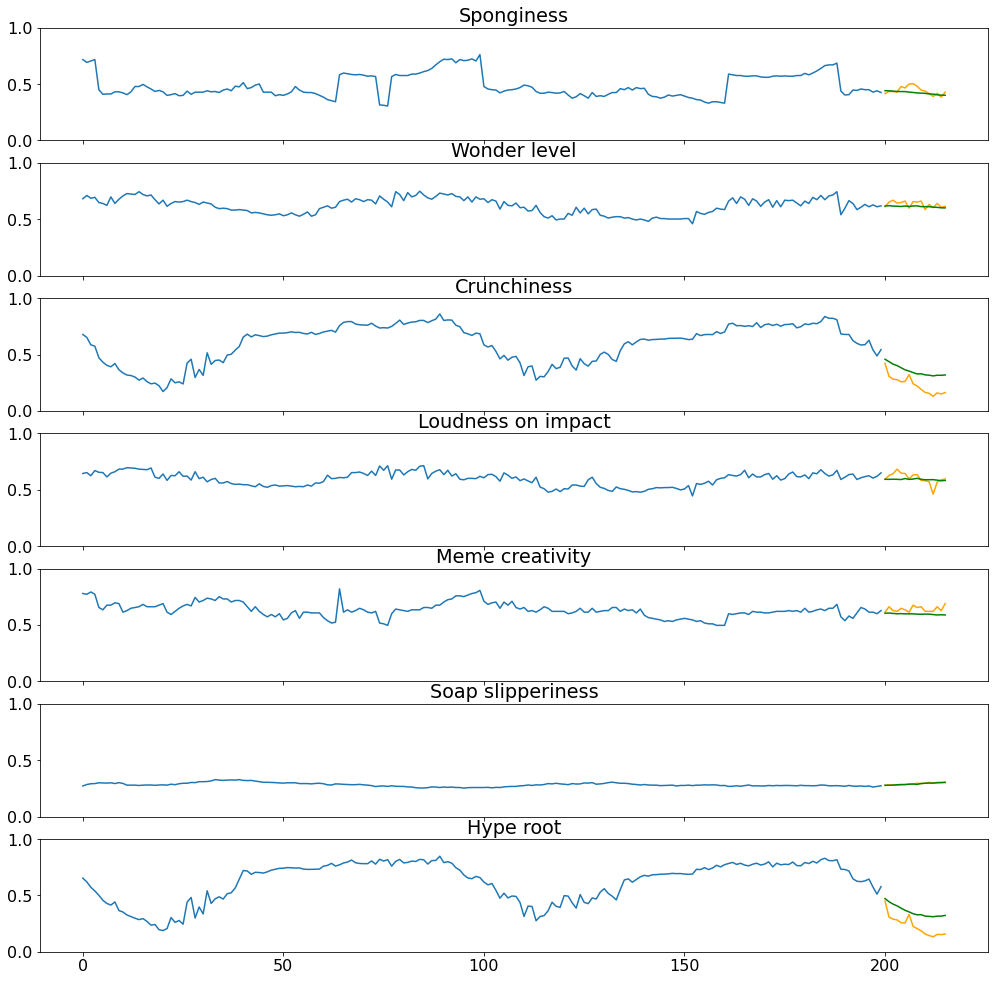

In [37]:
# See the results of the predictions 
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

## Predict the whole reg_telescope

In [38]:
# True telescope that we wish to predict 
reg_telescope = 864

X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((294, 200, 7), (294, 864, 7))

In [39]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
# For as many times as there are telescope in reg_telescope 
for reg in range(0,reg_telescope,telescope):
    # Predict the new telescope length part 
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):    # If you have yet to predict anything
        # Save it as first 
        reg_predictions = pred_temp       
    else:                           # f you have predicted something already 
        # Append it to the end of the prediction 
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)  
    
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [40]:
# Shape of the final prediction 
reg_predictions.shape

(294, 864, 7)

In [41]:
mean_squared_error  = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())

mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.010597663>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07329316>)

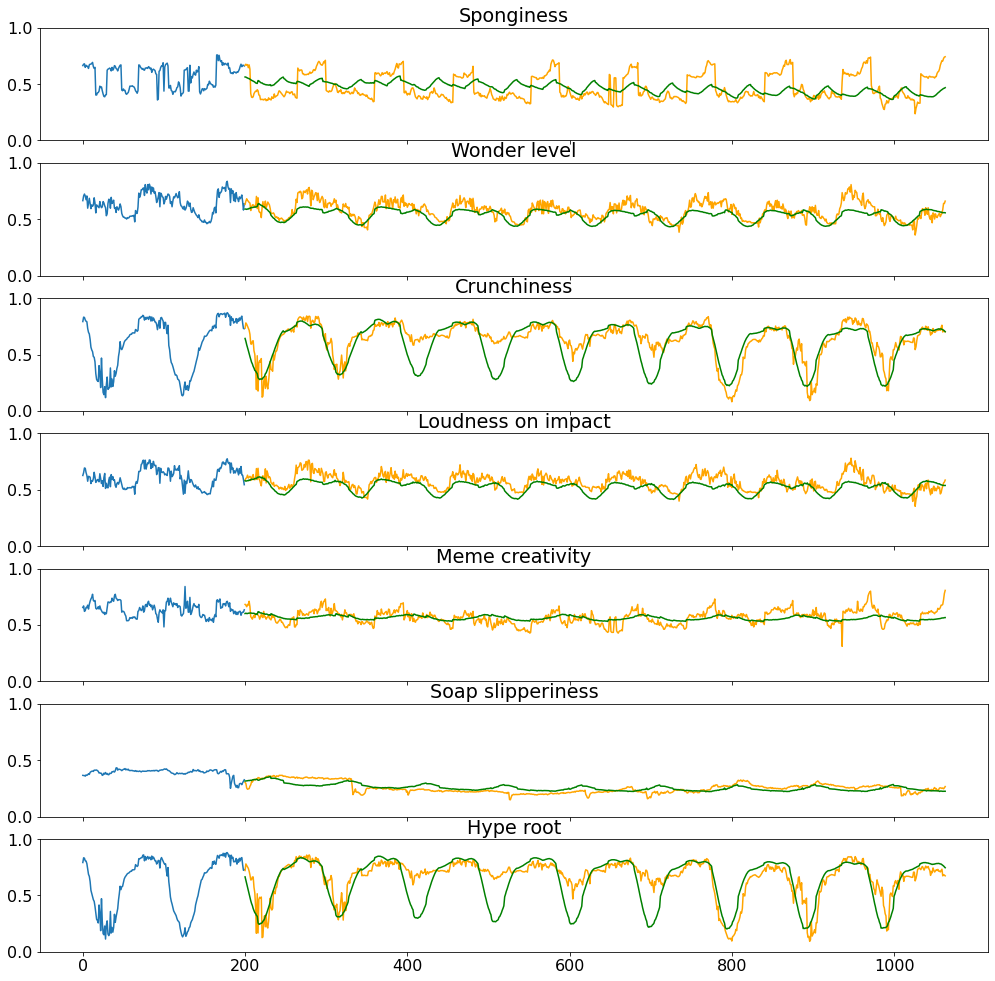

In [42]:
# See the prediction of the AR model 
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

In [43]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

## Predict the FUTURE with the AR model

In [44]:
# Take the last part of the dataset 
future = dataset[-window:]
# Normalize this last part 
future = (future-X_min)/(X_max-X_min)
# Expand the dimension 
future = np.expand_dims(future, axis=0)
# Display the shape 
future.shape

(1, 200, 7)

In [45]:
# Initialize the result np vector 
reg_future = np.array([])
# Initialize the future shifting np vector 
X_temp = future
# Predict every telescope until you cover the whole reg_telescope 
for reg in range(0,reg_telescope,telescope):
    # Predict with the model 
    pred_temp = model.predict(X_temp)
    # If first prediction 
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        # If not first then concatenate with what you have already predicted 
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    # Shift the window 
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

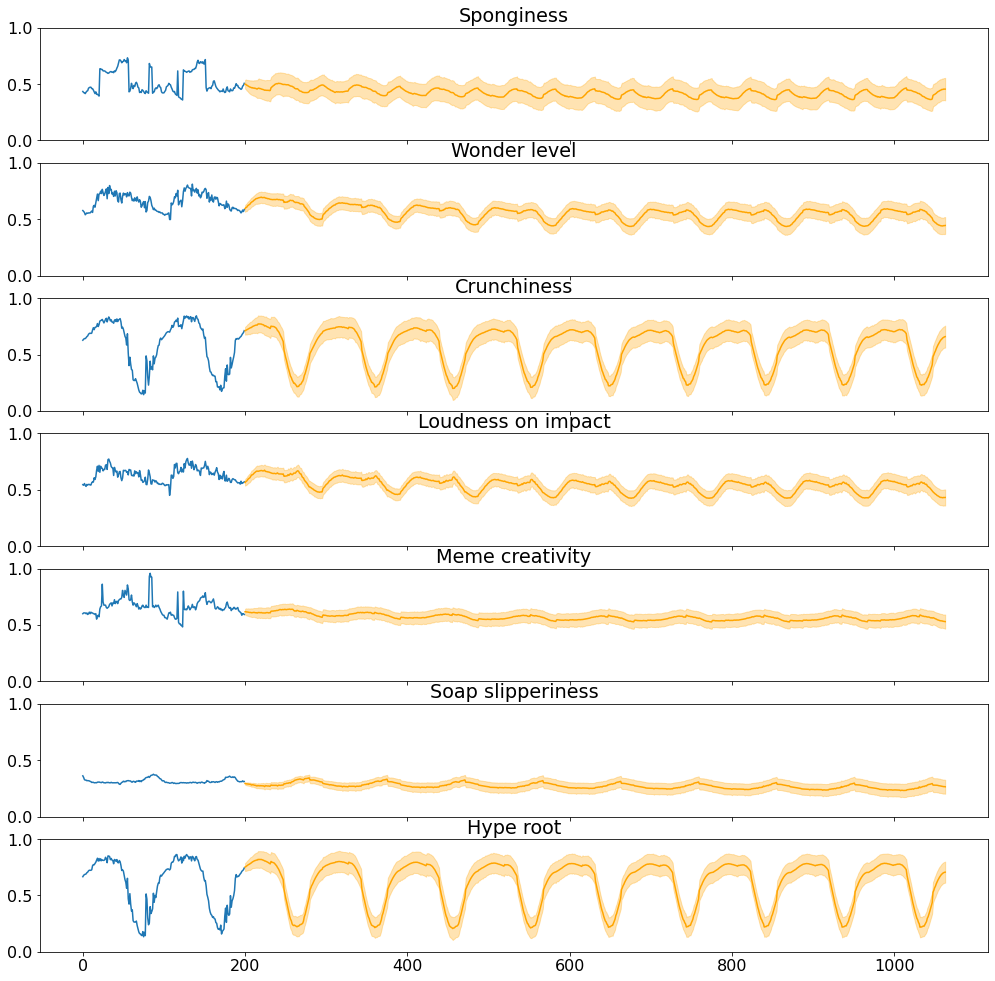

In [46]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
    
plt.show()

### NB the orange bands widens as t increases during each prediction 